Натренувати класифікатор на датасеті
https://archive.ics.uci.edu/ml/datasets/credit+approval
DecisionTreeClassifier


*   первинний аналіз даних (відстуність пропусків, наявність категоріальних фіч, duplicated, Nan) (+)
*   фича інжиніринг (побудувати 1-2 нові фічі) (+)
*   Убрать кореляцію в фічах (+)
*   поділ датасету на train, validate, test (+ random_state) (+)
*   GridSearchCV (+)
*   Scaling (+)
*   тренування базової моделі із дефолтними гіперпараметрами (кожну модель) (+)
*   підбір гіперпараметрів (кожну модель) (+)
*   побудувати модель різними способами (+)
*   Metrics: classification_report ... (+)
*   оцінка результатів (порівняння всіх на тестовій частині, описати яка краще) (+)
*  Графічний аналіз (+)
*  Побудувати дерева (+)


## INIT BLOCK

### Import Requirements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.container import BarContainer
from pandas.core.arrays.sparse.array import NaT
from pandas.core.groupby import DataFrameGroupBy
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, Lasso, LogisticRegression
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, precision_recall_curve,
                             precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE


### Init

In [2]:
RANDOM_STATE: int = 1729


def mount_google_drive() -> bool | None:
    """
    Function to mount Google Drive.
    :return: True if mounting is successful, None otherwise.
    """
    try:
        from google.colab.drive import mount

        mount(mountpoint="/content/drive")
        return True

    except Exception as error:
        print(f"Error while mounting Google Drive: {error}")
        raise


def get_data_frame(dataset_path: str, *args, sep: str = ",", **kwargs) -> pd.DataFrame | None:
    """
    Function to convert the dataset into a pd.DataFrame.
    :param sep: Separator for csv data, default - ",".
    :param dataset_path: Path or URL of the dataset.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    try:
        return pd.read_csv(filepath_or_buffer=dataset_path, sep=sep, **kwargs)

    except Exception as error:
        print(f"Error while converting dataset to NumPy array: {error}")
        raise


def main(dataset_path: str, *args, **kwargs) -> pd.DataFrame | None:
    """
    Main function to start the app.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    if mount_google_drive():
        import os

        if os.path.exists(path=dataset_path):
            return get_data_frame(dataset_path=dataset_path, *args, **kwargs)

        else:
            print("Dataset path doesn't exists.")
            raise FileNotFoundError


if __name__ == "__main__":
    credit_dataframe: pd.DataFrame | None = main(dataset_path="/content/drive/MyDrive/Hillel/Machine_Learning_Course/HW8/credit+approval/crx.data", header=None)

    if isinstance(credit_dataframe, pd.DataFrame):
        working_dataframe: pd.DataFrame = credit_dataframe.copy()  # TODO rename this variable according to dataset name

        target_column_name: str = "A16"
        features_names: list = ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15"]

        headers: list = features_names + [target_column_name]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data analysis, clining and optomization

### Перевіряємо на дублікати

In [3]:
print(f"{'Є дублікати, потрібна обробка датасету.' if working_dataframe.duplicated().sum() else 'Дублікатів немає.'}", end="\n\n")

Дублікатів немає.



### Обробка відсутніх значеннь

In [4]:
print(f"{'Є пропущені значення, потрібна обробка датасету.' if working_dataframe.isna().any().any() else 'Пропущених значень немає.'}", end="\n\n")
working_dataframe.info()
working_dataframe.head()

Пропущених значень немає.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    object 
 13  13      690 non-null    object 
 14  14      690 non-null    int64  
 15  15      690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [5]:
working_dataframe.replace(to_replace="?", value=pd.NA, inplace=True)
working_dataframe.dropna(inplace=True)
working_dataframe.reset_index(drop=True, inplace=True)

working_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       653 non-null    object 
 1   1       653 non-null    object 
 2   2       653 non-null    float64
 3   3       653 non-null    object 
 4   4       653 non-null    object 
 5   5       653 non-null    object 
 6   6       653 non-null    object 
 7   7       653 non-null    float64
 8   8       653 non-null    object 
 9   9       653 non-null    object 
 10  10      653 non-null    int64  
 11  11      653 non-null    object 
 12  12      653 non-null    object 
 13  13      653 non-null    object 
 14  14      653 non-null    int64  
 15  15      653 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 81.8+ KB


### Додаємо хедери

In [6]:
working_dataframe.columns = headers

working_dataframe.info()
working_dataframe.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      653 non-null    object 
 1   A2      653 non-null    object 
 2   A3      653 non-null    float64
 3   A4      653 non-null    object 
 4   A5      653 non-null    object 
 5   A6      653 non-null    object 
 6   A7      653 non-null    object 
 7   A8      653 non-null    float64
 8   A9      653 non-null    object 
 9   A10     653 non-null    object 
 10  A11     653 non-null    int64  
 11  A12     653 non-null    object 
 12  A13     653 non-null    object 
 13  A14     653 non-null    object 
 14  A15     653 non-null    int64  
 15  A16     653 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 81.8+ KB


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,00120,0,+
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0,t,g,00360,0,+
6,b,33.17,1.040,u,g,r,h,6.500,t,f,0,t,g,00164,31285,+
7,a,22.92,11.585,u,g,cc,v,0.040,t,f,0,f,g,00080,1349,+
8,b,54.42,0.500,y,p,k,h,3.960,t,f,0,f,g,00180,314,+
9,b,42.50,4.915,y,p,w,v,3.165,t,f,0,t,g,00052,1442,+


### Замінемо категорії таргета на числа, де "+" == 1, "-" == 0:

In [7]:
working_dataframe[target_column_name]: pd.Series = working_dataframe[target_column_name].replace(to_replace={"-": 0, "+": 1})
working_dataframe.head(10)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,00120,0,1
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0,t,g,00360,0,1
6,b,33.17,1.040,u,g,r,h,6.500,t,f,0,t,g,00164,31285,1
7,a,22.92,11.585,u,g,cc,v,0.040,t,f,0,f,g,00080,1349,1
8,b,54.42,0.500,y,p,k,h,3.960,t,f,0,f,g,00180,314,1
9,b,42.50,4.915,y,p,w,v,3.165,t,f,0,t,g,00052,1442,1


### Міняємо типи даних

In [8]:
columns_to_float: list = ["A2", "A14"]
working_dataframe[columns_to_float]: pd.DataFrame = working_dataframe[columns_to_float].astype(float)

working_dataframe.info()
working_dataframe.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      653 non-null    object 
 1   A2      653 non-null    float64
 2   A3      653 non-null    float64
 3   A4      653 non-null    object 
 4   A5      653 non-null    object 
 5   A6      653 non-null    object 
 6   A7      653 non-null    object 
 7   A8      653 non-null    float64
 8   A9      653 non-null    object 
 9   A10     653 non-null    object 
 10  A11     653 non-null    int64  
 11  A12     653 non-null    object 
 12  A13     653 non-null    object 
 13  A14     653 non-null    float64
 14  A15     653 non-null    int64  
 15  A16     653 non-null    int64  
dtypes: float64(4), int64(3), object(9)
memory usage: 81.8+ KB


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,120.0,0,1
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0,t,g,360.0,0,1
6,b,33.17,1.040,u,g,r,h,6.500,t,f,0,t,g,164.0,31285,1
7,a,22.92,11.585,u,g,cc,v,0.040,t,f,0,f,g,80.0,1349,1
8,b,54.42,0.500,y,p,k,h,3.960,t,f,0,f,g,180.0,314,1
9,b,42.50,4.915,y,p,w,v,3.165,t,f,0,t,g,52.0,1442,1


### Генеруємо статистику

In [9]:
working_dataframe.describe(include="all", percentiles=[.25, .5, .75])

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
count,653,653.000000,653.000000,653,653,653,653,653.000000,653,653,653.000000,653,653,653.000000,653.000000,653.000000
unique,2,NaN,NaN,3,3,14,9,NaN,2,2,NaN,2,3,NaN,NaN,NaN
top,b,NaN,NaN,u,g,c,v,NaN,t,f,NaN,f,g,NaN,NaN,NaN
freq,450,NaN,NaN,499,499,133,381,NaN,349,366,NaN,351,598,NaN,NaN,NaN
mean,NaN,31.503813,4.829533,NaN,NaN,NaN,NaN,2.244296,NaN,NaN,2.502297,NaN,NaN,180.359877,1013.761103,0.453292
std,NaN,11.838267,5.027077,NaN,NaN,NaN,NaN,3.371120,NaN,NaN,4.968497,NaN,NaN,168.296811,5253.278504,0.498195
min,NaN,13.750000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,22.580000,1.040000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.000000,NaN,NaN,73.000000,0.000000,0.000000
50%,NaN,28.420000,2.835000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,NaN,160.000000,5.000000,0.000000
75%,NaN,38.250000,7.500000,NaN,NaN,NaN,NaN,2.625000,NaN,NaN,3.000000,NaN,NaN,272.000000,400.000000,1.000000


## Feature Engineering

### Feature Encoding

In [10]:
encoder: OneHotEncoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.int8)

features_to_encode: list = ["A1", "A4", "A5", "A6", "A7", "A9", "A10", "A12", "A13"]
encoded_features: np.ndarray = encoder.fit_transform(X=working_dataframe[features_to_encode])

print(f"Encoded categories: {encoder.categories_}")
print(f"Number of encoded features: {encoder.n_features_in_}")
print(f"Names of encoded features: {encoder.feature_names_in_}")
print(f"Names of new columns: {encoder.get_feature_names_out()}", end="\n\n")

encoded_dataframe: pd.DataFrame = pd.DataFrame(data=encoded_features, columns=encoder.get_feature_names_out())
working_dataframe: pd.DataFrame = pd.concat([working_dataframe, encoded_dataframe], axis=1)
working_dataframe: pd.DataFrame = working_dataframe.drop(features_to_encode, axis=1)

working_dataframe.info()
working_dataframe

Encoded categories: [array(['a', 'b'], dtype=object), array(['l', 'u', 'y'], dtype=object), array(['g', 'gg', 'p'], dtype=object), array(['aa', 'c', 'cc', 'd', 'e', 'ff', 'i', 'j', 'k', 'm', 'q', 'r', 'w',
       'x'], dtype=object), array(['bb', 'dd', 'ff', 'h', 'j', 'n', 'o', 'v', 'z'], dtype=object), array(['f', 't'], dtype=object), array(['f', 't'], dtype=object), array(['f', 't'], dtype=object), array(['g', 'p', 's'], dtype=object)]
Number of encoded features: 9
Names of encoded features: ['A1' 'A4' 'A5' 'A6' 'A7' 'A9' 'A10' 'A12' 'A13']
Names of new columns: ['A1_a' 'A1_b' 'A4_l' 'A4_u' 'A4_y' 'A5_g' 'A5_gg' 'A5_p' 'A6_aa' 'A6_c'
 'A6_cc' 'A6_d' 'A6_e' 'A6_ff' 'A6_i' 'A6_j' 'A6_k' 'A6_m' 'A6_q' 'A6_r'
 'A6_w' 'A6_x' 'A7_bb' 'A7_dd' 'A7_ff' 'A7_h' 'A7_j' 'A7_n' 'A7_o' 'A7_v'
 'A7_z' 'A9_f' 'A9_t' 'A10_f' 'A10_t' 'A12_f' 'A12_t' 'A13_g' 'A13_p'
 'A13_s']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 47 columns):
 #   Column  Non-Null C

,A2,A3,A8,A11,A14,A15,A16,A1_a,A1_b,A4_l,...,A7_z,A9_f,A9_t,A10_f,A10_t,A12_f,A12_t,A13_g,A13_p,A13_s
0,30.83,0.000,1.25,1,202.0,0,1,0,1,0,...,0,0,1,0,1,1,0,1,0,0
1,58.67,4.460,3.04,6,43.0,560,1,1,0,0,...,0,0,1,0,1,1,0,1,0,0
2,24.50,0.500,1.50,0,280.0,824,1,1,0,0,...,0,0,1,1,0,1,0,1,0,0
3,27.83,1.540,3.75,5,100.0,3,1,0,1,0,...,0,0,1,0,1,0,1,1,0,0
4,20.17,5.625,1.71,0,120.0,0,1,0,1,0,...,0,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,21.08,10.085,1.25,0,260.0,0,0,0,1,0,...,0,1,0,1,0,1,0,1,0,0
649,22.67,0.750,2.00,2,200.0,394,0,1,0,0,...,0,1,0,0,1,0,1,1,0,0
650,25.25,13.500,2.00,1,200.0,1,0,1,0,0,...,0,1,0,0,1,0,1,1,0,0
651,17.92,0.205,0.04,0,280.0,750,0,0,1,0,...,0,1,0,1,0,1,0,1,0,0


### Візуалізація даних

<Axes: >

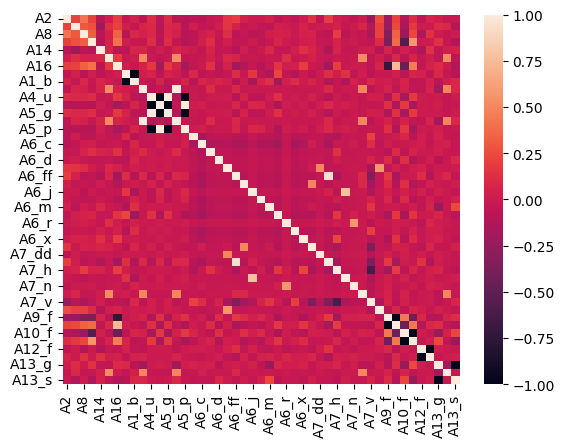

In [11]:
working_dataframe_corr_matrix = working_dataframe.corr()  # full heatmap
sns.heatmap(data=working_dataframe_corr_matrix)

Є кореляція між деякмими фічами, прибираємо кореляцію.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A2      653 non-null    float64
 1   A3      653 non-null    float64
 2   A8      653 non-null    float64
 3   A11     653 non-null    int64  
 4   A14     653 non-null    float64
 5   A15     653 non-null    int64  
 6   A16     653 non-null    int64  
 7   A1_a    653 non-null    int8   
 8   A4_l    653 non-null    int8   
 9   A4_u    653 non-null    int8   
 10  A6_aa   653 non-null    int8   
 11  A6_c    653 non-null    int8   
 12  A6_cc   653 non-null    int8   
 13  A6_d    653 non-null    int8   
 14  A6_e    653 non-null    int8   
 15  A6_ff   653 non-null    int8   
 16  A6_i    653 non-null    int8   
 17  A6_j    653 non-null    int8   
 18  A6_k    653 non-null    int8   
 19  A6_m    653 non-null    int8   
 20  A6_q    653 non-null    int8   
 21  A6_r    653 non-null    int8   
 22  A6

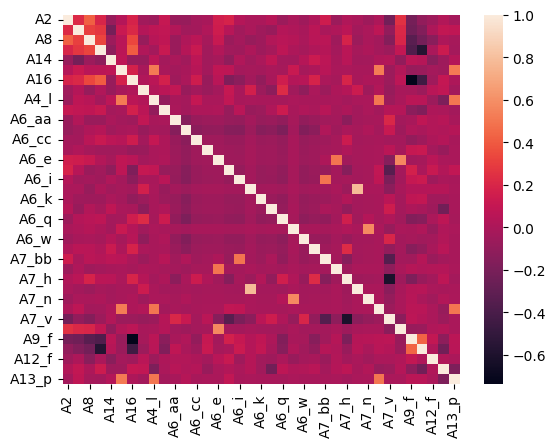

In [12]:
columns_to_delete: list = ["A1_b", "A4_y", "A5_g", "A5_gg", "A5_p", "A9_t", "A10_t", "A12_t", "A13_s", "A7_ff"]
working_dataframe: pd.DataFrame = working_dataframe.drop(columns_to_delete, axis=1)
working_dataframe_corr_matrix = working_dataframe.corr()  # full heatmap
sns.heatmap(data=working_dataframe_corr_matrix)
working_dataframe.info()

### Так як ми не знаємо що означають фічі та їх природу походження, робимо автоматично згенеровані фічі за допомогою TSNE

In [13]:
# x_tsne = working_dataframe.copy().drop(target_column_name, axis=1)
# x_embedded = TSNE(n_components=3, learning_rate="auto", init="pca", method="exact", perplexity=7, random_state=RANDOM_STATE).fit_transform(X=x_tsne)
# working_dataframe[["tsne_1", "tsne_2", "tsne_3"]] = x_embedded

# working_dataframe_tsne_corr_matrix = working_dataframe.corr()
# sns.heatmap(data=working_dataframe_tsne_corr_matrix)
# working_dataframe.info()

Після десяти тестів з різними згенерованими фічами та їх кількістю, виявилося, що зросту предикту вони не надають. Тому можна залишити тільки дефолтні.

## Preparing data for training

### Розбиваємо датасет на фічі та таргет

In [14]:
x_features: pd.DataFrame = working_dataframe.copy().drop(target_column_name, axis=1)
y_target: pd.Series = working_dataframe[target_column_name]

### Масштабування фічів

Ні один скалер не показав зросту точності, тому немає сенсу взагалі їх використовувати в даному випадку, з дервами рішеннь.

In [15]:
# scaler: StandardScaler = StandardScaler().fit(X=x_features)
# scaler: StandardScaler = PowerTransformer().fit(X=x_features)
# scaler: StandardScaler = RobustScaler().fit(X=x_features)
# x_scaled: np.ndarray = scaler.transform(X=x_features)

x_scaled: np.ndarray = x_features

### Розбиваємо дані на тренувальну, валідаційну та тестову частину

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_target, test_size=0.33, random_state=RANDOM_STATE, stratify=y_target)
x_validate, x_test, y_validate, y_test = train_test_split(x_test, y_test, test_size=0.33, random_state=RANDOM_STATE, stratify=y_test)

print(x_train.shape)
print(x_validate.shape)
print(x_test.shape)

(437, 36)
(144, 36)
(72, 36)


### Перевіряємо розподіл классів

In [17]:
print(f"Загальний таргет:\n{working_dataframe[target_column_name].value_counts()}", end="\n\n")
print(f"Тренувальний таргет:\n{y_train.value_counts()}")

Загальний таргет:
0    357
1    296
Name: A16, dtype: int64

Тренувальний таргет:
0    239
1    198
Name: A16, dtype: int64


Бачімо, що класи майже збалансовані, і різниця невелика (((239 - 198) / 239) * 100 ≈ 17.15%). Але всеодно спробуємо для експерименту збалансувати, та подивитись чи буде зріст предикту.

### Балансування классів

Тести з балансуванням класів не дали жодного зросту, тому немає сенсу їх взагалі використовувати в даному випадку.

In [18]:
# balancer = BorderlineSMOTE(random_state=RANDOM_STATE, k_neighbors=5, sampling_strategy="auto")  # кращій результат 0.86
# balancer = KMeansSMOTE(random_state=RANDOM_STATE, k_neighbors=2, sampling_strategy="auto")  #  кращій результат 0.86
# balancer = SVMSMOTE(random_state=RANDOM_STATE, k_neighbors=5, sampling_strategy="auto") #  кращій результат 0.86
# x_resampled, y_resampled = balancer.fit_resample(X=x_train, y=y_train)
# print(x_resampled.shape)
# print(f"Тренувальний таргет:\n{y_resampled.value_counts()}")
x_resampled, y_resampled = x_train, y_train

# FIT PREDICT

### Functions for fit models, make predict and generate metrics

In [19]:
def print_model_name(name: str) -> None:
    print("'" * 60)
    print(f"MODEL: {name}")

In [20]:
def value_results_main(model, predict, y_test):
    accuracy = accuracy_score(y_true=y_test, y_pred=predict)
    precision = precision_score(y_true=y_test, y_pred=predict, average="micro")
    recall = recall_score(y_true=y_test, y_pred=predict, average="micro")
    f1 = f1_score(y_true=y_test, y_pred=predict, average="micro")

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    print("'" * 60)

In [21]:
def value_results(model, name:str, predict, y_test):
    print_model_name(name=name)
    value_results_main(model=model, predict=predict, y_test=y_test)

In [22]:
def train_model(model_class, name: str, grid_params=None):
    print_model_name(name=name)

    if grid_params:
        model: GridSearchCV = GridSearchCV(estimator=model_class, param_grid=grid_params).fit(X=x_resampled, y=y_resampled)

        print("Best params: ", model.best_params_)
        print("Best score: ", model.best_score_)

    else:
        model = model_class().fit(X=x_resampled, y=y_resampled)

    y_pred = model.predict(X=x_validate)

    print(f"Classification report:\n{classification_report(y_true=y_validate, y_pred=y_pred)}")

    value_results_main(model=model, predict=y_pred, y_test=y_validate)

    return model


### Тренуємо моделі

In [23]:
## DecisionTreeClassifier() with default hyperparams
model_decision_tree_classifier: DecisionTreeClassifier = train_model(model_class=DecisionTreeClassifier, name="DecisionTreeClassifier with default hyperparameters")

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: DecisionTreeClassifier with default hyperparameters
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81        79
           1       0.79      0.71      0.75        65

    accuracy                           0.78       144
   macro avg       0.79      0.78      0.78       144
weighted avg       0.79      0.78      0.78       144

Accuracy: 0.7847222222222222
Precision: 0.7847222222222222
Recall: 0.7847222222222222
F1 Score: 0.7847222222222222
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


In [24]:
## DecisionTreeClassifier() з підбіром параметрів через GridSearchCV
grid_decision_tree_classifier_params = {
    "criterion": ["gini", "entropy", "log_loss"], # ["gini", "entropy", "log_loss"]
    "splitter": ["best"],  # ["best", "random"]
    "max_depth": [2],  # int default=None,
    "min_samples_split": [2],  # int or float, default=2,
    "min_samples_leaf": [1], #  int or float, default=1,
    "min_weight_fraction_leaf": [0.0], # float default=0.0,
    "max_features": [None,],  # ["auto", "sqrt", "log2", None] int, float or {“auto”, “sqrt”, “log2”}, default=None
    "random_state": [RANDOM_STATE],
    "max_leaf_nodes": [None],  # int, default=None,
    "min_impurity_decrease": [0.0],  # float, default=0.0,
    "class_weight": [None, "balanced"],  # dict, list of dict or “balanced”, default=None
    "ccp_alpha": [0.0],  # non-negative float, default=0.0
}
model_decision_tree_classifier_grid = train_model(model_class=DecisionTreeClassifier(), name="DecisionTreeClassifier with Grid hyperparameters", grid_params=grid_decision_tree_classifier_params)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: DecisionTreeClassifier with Grid hyperparameters
Best params:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1729, 'splitter': 'best'}
Best score:  0.8765151515151516
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        79
           1       0.76      0.91      0.83        65

    accuracy                           0.83       144
   macro avg       0.83      0.83      0.83       144
weighted avg       0.84      0.83      0.83       144

Accuracy: 0.8263888888888888
Precision: 0.8263888888888888
Recall: 0.8263888888888888
F1 Score: 0.8263888888888888
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


In [25]:
## ExtraTreeClassifier() with default hyperparams
model_e_decision_tree_classifier: ExtraTreeClassifier = train_model(model_class=ExtraTreeClassifier, name="ExtraTreeClassifier with default hyperparameters")

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: ExtraTreeClassifier with default hyperparameters
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79        79
           1       0.76      0.68      0.72        65

    accuracy                           0.76       144
   macro avg       0.76      0.75      0.75       144
weighted avg       0.76      0.76      0.76       144

Accuracy: 0.7569444444444444
Precision: 0.7569444444444444
Recall: 0.7569444444444444
F1 Score: 0.7569444444444444
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


In [26]:
## ExtraTreeClassifier() з підбіром параметрів через GridSearchCV
grid_e_decision_tree_classifier_params = {
    "criterion": ["gini", "entropy", "log_loss"], # ["gini", "entropy", "log_loss"]
    "splitter": ["best", "random"],  # ["best", "random"]
    "max_depth": [2, None],  # int default=None,
    "min_samples_split": [2],  # int or float, default=2,
    "min_samples_leaf": [1], #  int or float, default=1,
    "min_weight_fraction_leaf": [0.0], # float default=0.0,
    "max_features": [None],  # ["auto", "sqrt", "log2", None] int, float or {“auto”, “sqrt”, “log2”}, default=None
    "random_state": [RANDOM_STATE],
    "max_leaf_nodes": [None],  # int, default=None,
    "min_impurity_decrease": [0.0],  # float, default=0.0,
    "class_weight": [None, "balanced"],  # dict, list of dict or “balanced”, default=None
    "ccp_alpha": [0.0],  # non-negative float, default=0.0
}
model_e_decision_tree_classifier_grid = train_model(model_class=ExtraTreeClassifier(), name="ExtraTreeClassifier with Grid hyperparameters", grid_params=grid_e_decision_tree_classifier_params)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: ExtraTreeClassifier with Grid hyperparameters
Best params:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1729, 'splitter': 'random'}
Best score:  0.8810867293625915
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        79
           1       0.76      0.91      0.83        65

    accuracy                           0.83       144
   macro avg       0.83      0.83      0.83       144
weighted avg       0.84      0.83      0.83       144

Accuracy: 0.8263888888888888
Precision: 0.8263888888888888
Recall: 0.8263888888888888
F1 Score: 0.8263888888888888
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


### Порівняння результатів

In [27]:
value_results(model=model_decision_tree_classifier, name="DecisionTreeClassifier with default hyperparameters",
              predict=model_decision_tree_classifier.predict(X=x_test), y_test=y_test)

value_results(model=model_decision_tree_classifier_grid, name="DecisionTreeClassifier with Grid hyperparameters",
              predict=model_decision_tree_classifier_grid.predict(X=x_test), y_test=y_test)

value_results(model=model_e_decision_tree_classifier, name="ExtraTreeClassifier with default hyperparameters",
              predict=model_e_decision_tree_classifier.predict(X=x_test), y_test=y_test)

value_results(model=model_e_decision_tree_classifier_grid, name="ExtraTreeClassifier with Grid hyperparameters",
              predict=model_e_decision_tree_classifier_grid.predict(X=x_test), y_test=y_test)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: DecisionTreeClassifier with default hyperparameters
Accuracy: 0.8194444444444444
Precision: 0.8194444444444444
Recall: 0.8194444444444444
F1 Score: 0.8194444444444444
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: DecisionTreeClassifier with Grid hyperparameters
Accuracy: 0.8611111111111112
Precision: 0.8611111111111112
Recall: 0.8611111111111112
F1 Score: 0.8611111111111112
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: ExtraTreeClassifier with default hyperparameters
Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1 Score: 0.75
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: ExtraTreeClassifier with Grid hyperparameters
Accuracy: 0.8611111111111112
Precision: 0.8611111111111112
R

### Дерева

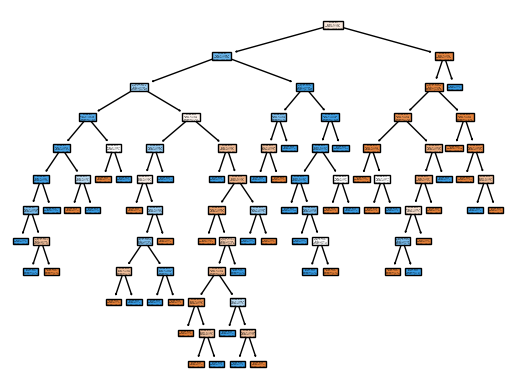

In [28]:
# DecisionTreeClassifier with default hyperparameters
plt.figure()
plot_tree(model_decision_tree_classifier, filled=True, node_ids=True)
plt.show()

# Стандартне дерево з дефолтними параметрами, перенавчання не помітно, рівнів не багато, глибина не велика.

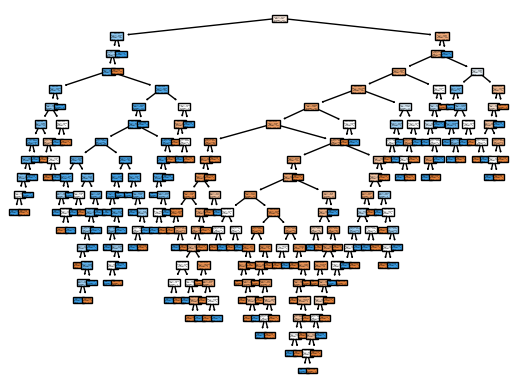

In [29]:
# ExtraTreeClassifier with default hyperparameters
plt.figure()
plot_tree(model_e_decision_tree_classifier, filled=True, node_ids=True)
plt.show()

# На схемі можна побачити, що дерево побудувалося дуже складне, та перенавчене.

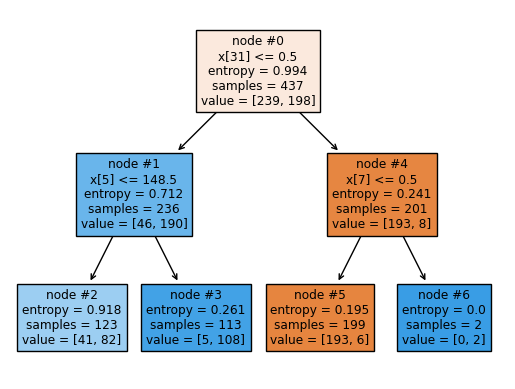

In [30]:
# DecisionTreeClassifier with Grid hyperparameters
plt.figure()
plot_tree(model_decision_tree_classifier_grid.best_estimator_, filled=True, node_ids=True)
plt.show()

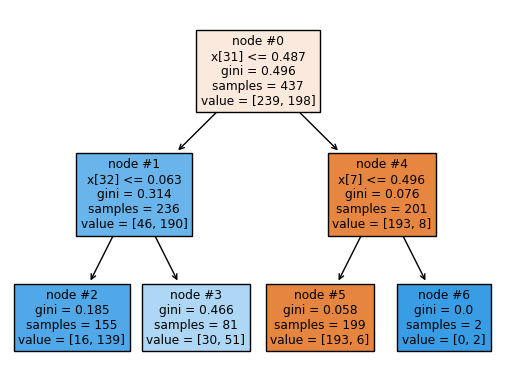

In [31]:
# ExtraTreeClassifier with Grid hyperparameters
plt.figure()
plot_tree(model_e_decision_tree_classifier_grid.best_estimator_, filled=True, node_ids=True)
plt.show()

# На останніх двох можна помітити, що хоч метрики і однакові, і кількість нодів, гілок... однакова, але дерева побудувались з різними коефіцієнтами.

# Висновок

Тести проводились на різних комбінаціх моделей, скалерів, балансерів класів, з та без нових фічів.

З усіх проведених тестів, найкращі стабільні результати показали дві моделі з такою комбінацією:

*  Features: Всі дефолтні фічі + згенеровані фічі за допомогою TSNE, але додаткові фічі ніякого зрісту предикту не дають
*  Scaler: Ніякий скалер не показав жодного зросту точності предікта
*  Class balancer: Також немає зросту предікту з жодним типом балансування класів
*  MODEL:
  1.   DecisionTreeClassifier with Grid hyperparameters
  2.   ExtraTreeClassifier with Grid hyperparameters

F1 Score на багатьох тестах складав однакові 0.86. Це повʼязано з тим, що "під капотом" моделі працюють однаково (або майже однаково), та найкращий результат показують і з однаковими гиперпараметрами, і з обраними через GridSearch.

Максимальний результат (f1 = 0.9) одноразово показала модель ExtraTreeClassifier with default hyperparameters. Скоріше за все це повʼязано з параметром "splitter", який за замовчення приймає "random".